### 1. Introdução e Configuração do Ambiente
Este notebook documenta o processo de desenvolvimento de um modelo de machine learning para prever o sucesso de startups. O objetivo é construir uma solução robusta e bem documentada, desde a análise exploratória dos dados até à construção, avaliação e otimização de um modelo preditivo.

A primeira etapa consiste na configuração do ambiente e na importação das bibliotecas necessárias para o projeto.

In [4]:
# PASSO 1: CONFIGURAÇÃO DO AMBIENTE E IMPORTAÇÃO DAS BIBLIOTECAS

# Bibliotecas para manipulação e análise de dados
import pandas as pd
import numpy as np
import warnings

# Bibliotecas para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Componentes do Scikit-learn para pré-processamento, modelagem e seleção
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Configurações globais
warnings.filterwarnings('ignore')
sns.set_style("whitegrid") 

print(" PASSO 1 CONCLUÍDO: Ambiente configurado com todas as bibliotecas ")

 PASSO 1 CONCLUÍDO: Ambiente configurado com todas as bibliotecas 


### 2. Carregamento e Análise Inicial dos Dados
Com o ambiente preparado, o próximo passo é carregar os dados. Foi utilizado o pandas para ler os arquivos train.csv e test.csv. O bloco de código try-except foi adicionado para garantir que o notebook funcione tanto no ambiente da competição (Kaggle) como num ambiente local, tratando diferentes caminhos para os arquivos.

Após o carregamento, realizamos uma verificação inicial para entender a estrutura dos dados:

.shape: Confere o número de linhas e colunas.

.info(): Mostra os tipos de dados de cada coluna e a contagem de valores nulos.

.describe(): Apresenta estatísticas descritivas (média, desvio padrão, etc.) para as colunas numéricas.

Esta primeira análise é fundamental para ter uma visão geral da qualidade e das características dos dados.

In [5]:
 # Carregamento dos dados a partir dos caminhos fornecidos
try:
    train_df = pd.read_csv("train.csv")
    test_df = pd.read_csv("test.csv")
    print("Dados carregados com sucesso.")
    print("Dimensões do conjunto de treino:", train_df.shape)
    print("Dimensões do conjunto de teste:", test_df.shape)
except FileNotFoundError:
    print("ERRO: Arquivos não encontrados. A verificar caminhos locais.")
    # Fallback para execução em ambiente local
    train_df = pd.read_csv("train.csv")
    test_df = pd.read_csv("test.csv")
    print("Dados carregados com sucesso do diretório local.")

# Exibição de informações gerais sobre o dataset de treino
print("\nInformações sobre os tipos de dados e valores nulos:")
train_df.info()

print("\nEstatísticas descritivas das variáveis numéricas:")
print(train_df.describe())

Dados carregados com sucesso.
Dimensões do conjunto de treino: (646, 33)
Dimensões do conjunto de teste: (277, 32)

Informações sobre os tipos de dados e valores nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        646 non-null    int64  
 1   age_first_funding_year    611 non-null    float64
 2   age_last_funding_year     637 non-null    float64
 3   age_first_milestone_year  508 non-null    float64
 4   age_last_milestone_year   535 non-null    float64
 5   relationships             646 non-null    int64  
 6   funding_rounds            646 non-null    int64  
 7   funding_total_usd         646 non-null    int64  
 8   milestones                646 non-null    int64  
 9   is_CA                     646 non-null    int64  
 10  is_NY                     646 non-null    int64  
 11  is_MA 

### 3. Análise Exploratória de Dados (EDA)
Antes de construir qualquer modelo, precisamos de "conversar" com os nossos dados. A Análise Exploratória de Dados (EDA) serve exatamente para isso.

Começamos por analisar a nossa variável alvo, labels, que indica se uma startup teve sucesso (1) ou não (0). Criamos um gráfico de barras para visualizar a distribuição destas duas classes. Este passo é crucial para perceber se o nosso conjunto de dados está balanceado ou se uma classe é muito mais frequente que a outra, o que pode influenciar a performance do modelo.

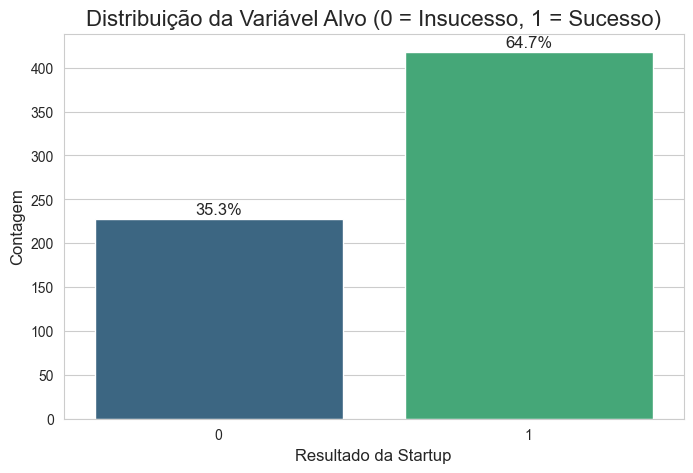

In [6]:
plt.figure(figsize=(8, 5))
sns.countplot(x='labels', data=train_df, palette='viridis')
plt.title("Distribuição da Variável Alvo (0 = Insucesso, 1 = Sucesso)", fontsize=16)
plt.xlabel("Resultado da Startup", fontsize=12)
plt.ylabel("Contagem", fontsize=12)
total = len(train_df)
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width()/2., height+5,
                f'{height/total:.1%}',
                ha="center", fontsize=12)
plt.show()

### 3.1. Análise de Correlação entre as Variáveis
Para aprofundar a nossa compreensão dos dados, vamos analisar a correlação entre as variáveis numéricas. A correlação mede a força e a direção da relação linear entre duas variáveis.

1. Mapa de Calor (Heatmap):
Criamos um mapa de calor para visualizar a matriz de correlação de forma gráfica. A interpretação é a seguinte:

Cores quentes (próximas ao vermelho): Indicam uma correlação positiva forte. Quando o valor de uma variável aumenta, o da outra tende a aumentar também.

Cores frias (próximas ao azul): Indicam uma correlação negativa forte. Quando o valor de uma variável aumenta, o da outra tende a diminuir.

Cores neutras (próximas do branco): Indicam pouca ou nenhuma correlação linear.

Este mapa ajuda-nos a identificar rapidamente quais variáveis se movem em conjunto e a detetar possíveis problemas de multicolinearidade (features que contêm informação redundante).

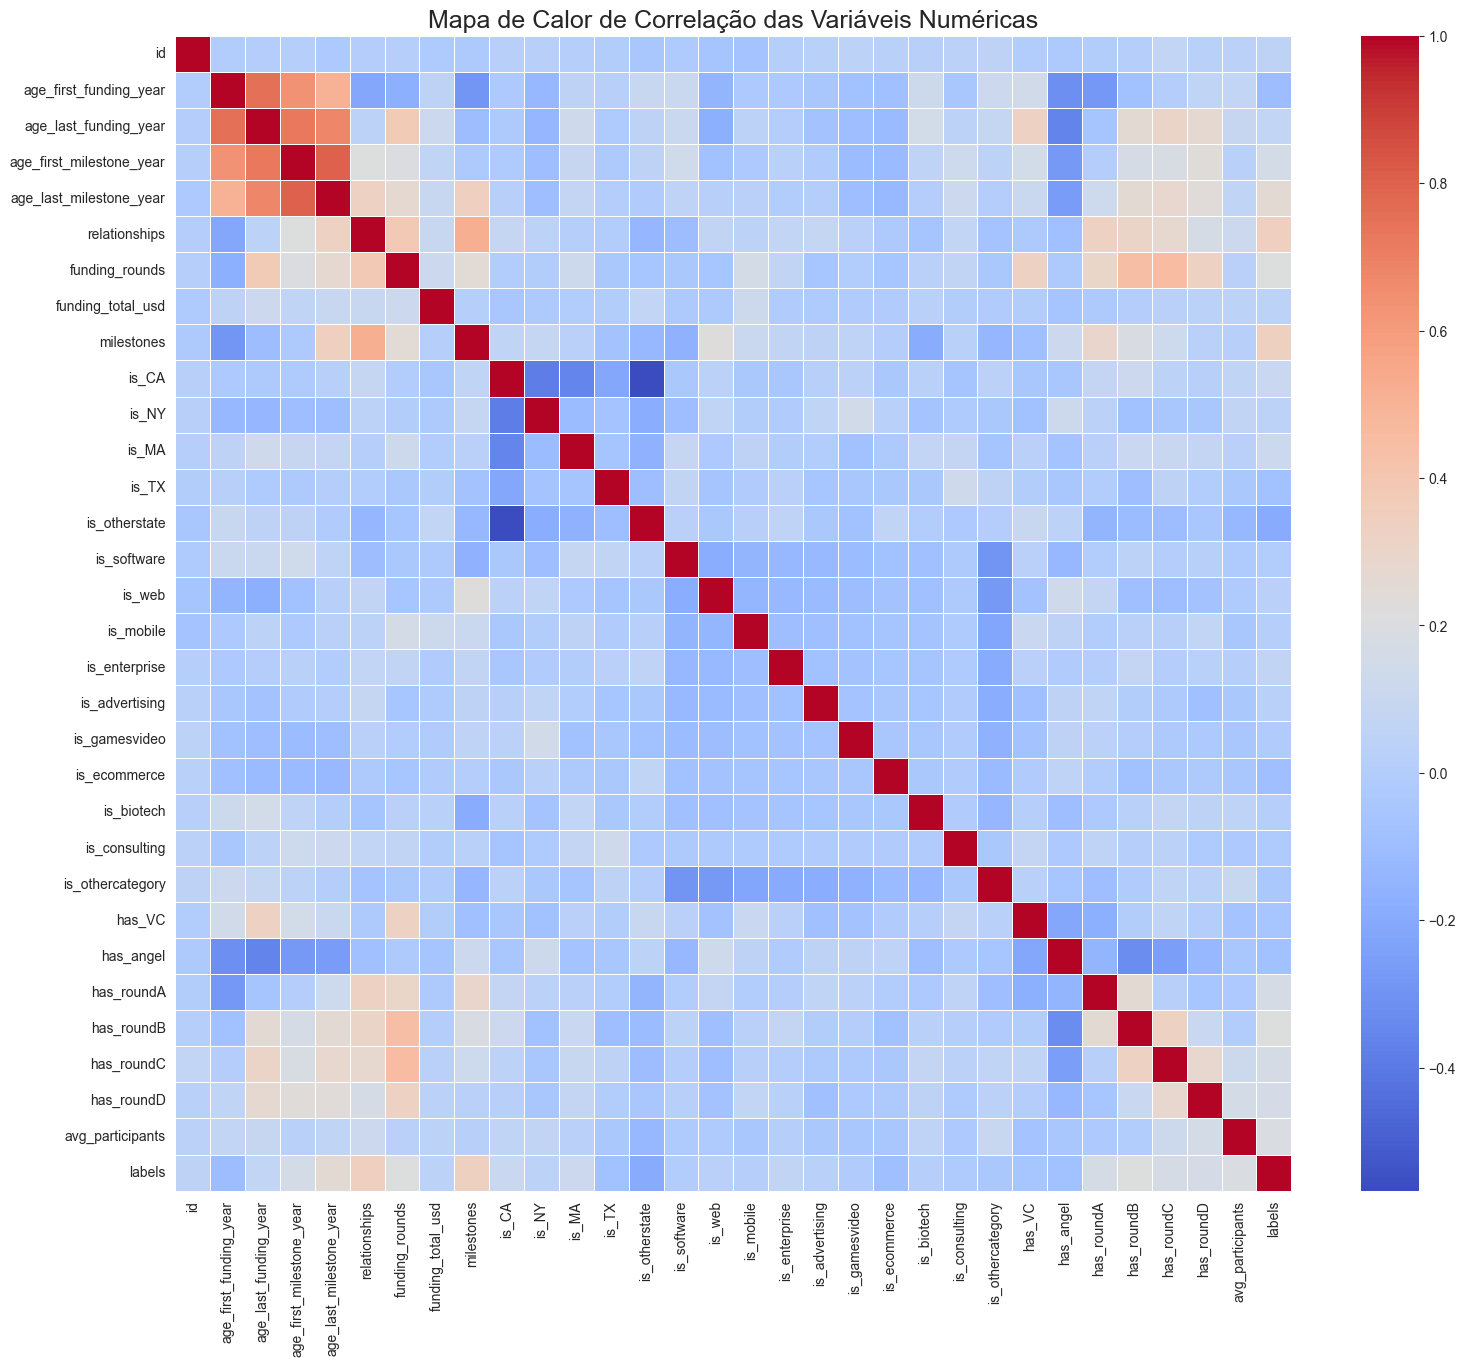


Correlação das features com 'labels':
labels                     1.000000
relationships              0.342841
milestones                 0.335149
age_last_milestone_year    0.257261
has_roundB                 0.214299
funding_rounds             0.212760
avg_participants           0.194482
has_roundC                 0.172943
has_roundA                 0.171953
has_roundD                 0.166680
Name: labels, dtype: float64


In [7]:
# Selecionando apenas colunas numéricas para o mapa de calor
numeric_cols = train_df.select_dtypes(include=np.number)
correlation_matrix = numeric_cols.corr()

plt.figure(figsize=(18, 15))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Mapa de Calor de Correlação das Variáveis Numéricas', fontsize=18)
plt.show()

# Correlação com a variável alvo
print("\nCorrelação das features com 'labels':")
print(correlation_matrix['labels'].sort_values(ascending=False).head(10))

### 3.2. Formulação de Hipóteses
Com base na análise exploratória inicial e no conhecimento geral sobre o ecossistema de startups, formulamos três hipóteses centrais que acreditamos que influenciam a probabilidade de sucesso de uma empresa. Estas hipóteses guiarão a nossa interpretação dos resultados do modelo.

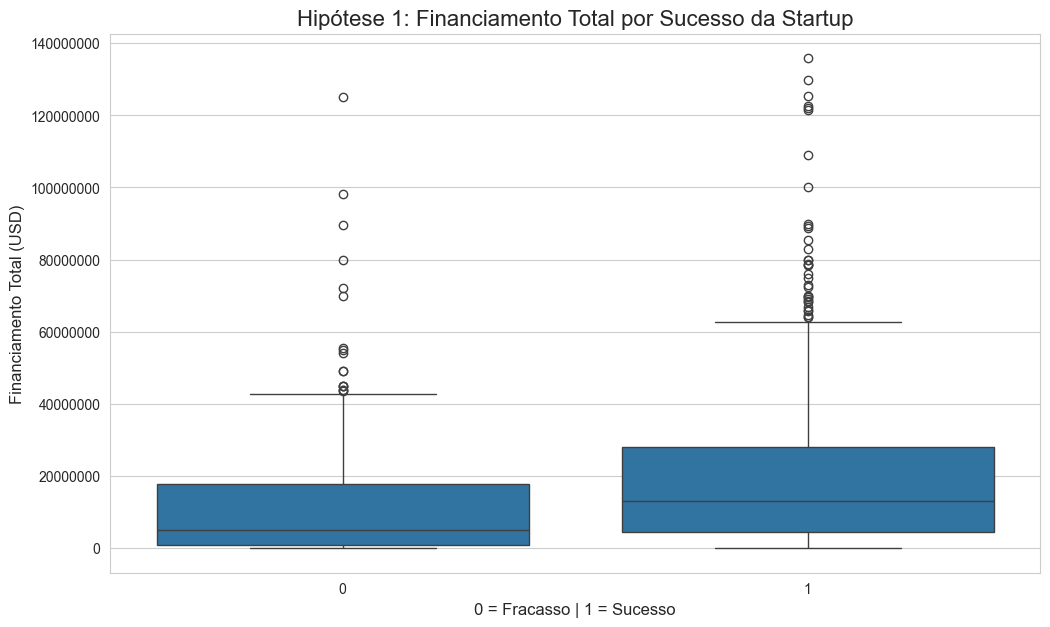

In [8]:
# Filtro de outliers para otimizar a visualização, focando nos 99% centrais dos dados
quantile_99 = train_df['funding_total_usd'].quantile(0.99)
data_to_plot = train_df[train_df['funding_total_usd'] < quantile_99]

plt.figure(figsize=(12, 7))
sns.boxplot(x='labels', y='funding_total_usd', data=data_to_plot)
plt.title('Hipótese 1: Financiamento Total por Sucesso da Startup', fontsize=16)
plt.xlabel('0 = Fracasso | 1 = Sucesso', fontsize=12)
plt.ylabel('Financiamento Total (USD)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Conclusão da Hipótese 1: A visualização corrobora a hipótese. A mediana e a dispersão interquartil do financiamento para startups de sucesso (1) são substancialmente mais elevadas, indicando uma forte correlação positiva entre o capital captado e o sucesso.

#### Hipótese 2: Startups com uma rede de contatos mais robusta (relationships) apresentam maior taxa de sucesso.

Nesta segunda análise, investiga se uma rede de contatos mais forte (relationships) está associada a uma maior probabilidade de sucesso. Uma rede robusta pode proporcionar acesso a investidores, mentores, parceiros e potenciais clientes.

Para focar na tendência central e na distribuição principal dos dados,removeu os outliers da visualização (showfliers=False). Se a caixa e a linha da mediana para as startups de sucesso (1) estiverem posicionadas mais acima no gráfico, isso sugere que, em geral, empresas bem-sucedidas tendem a ter uma rede de contactos maior, apoiando a hipótese.

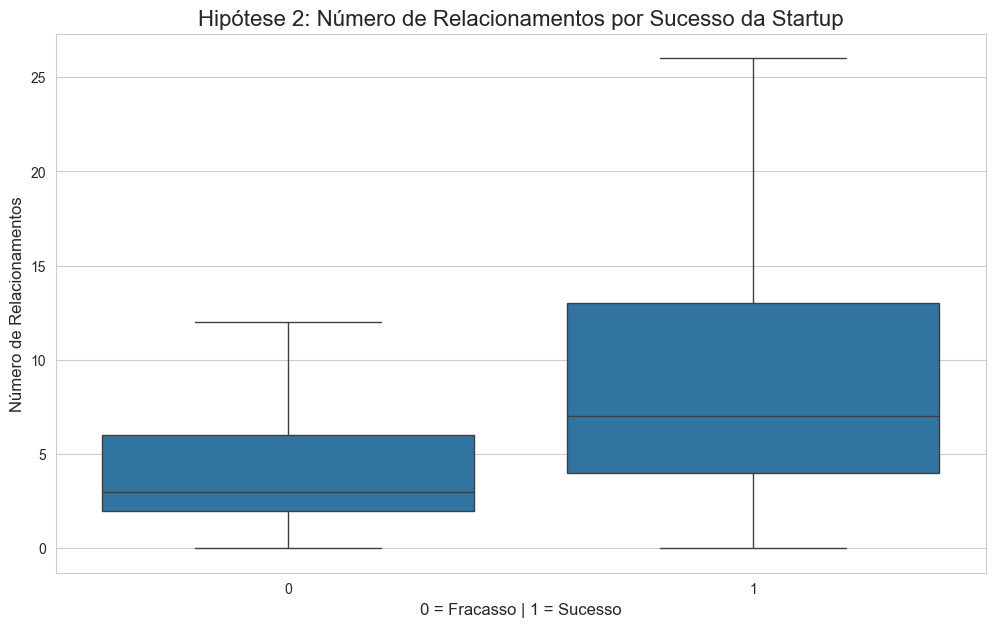

In [9]:
# A opção showfliers=False é usada para focar na distribuição principal
plt.figure(figsize=(12, 7))
sns.boxplot(x='labels', y='relationships', data=train_df, showfliers=False)
plt.title('Hipótese 2: Número de Relacionamentos por Sucesso da Startup', fontsize=16)
plt.xlabel('0 = Fracasso | 1 = Sucesso', fontsize=12)
plt.ylabel('Número de Relacionamentos', fontsize=12)
plt.show()

Conclusão da Hipótese 2: Os dados suportam a hipótese. Startups bem-sucedidas (1) demonstram uma distribuição de relacionamentos com valores significativamente mais altos, sugerindo que um networking forte é um fator importante.

#### Hipótese 3: A localização num polo tecnológico como a Califórnia (is_CA) está associada a uma maior taxa de sucesso.

Na terceira hipótese testa se estar num polo tecnológico como a Califórnia (is_CA) aumenta a chance de sucesso. Calculamos a taxa de sucesso percentual para startups dentro e fora da Califórnia e exibimos o resultado num gráfico de barras. Este gráfico permite uma comparação direta e clara entre os dois grupos.

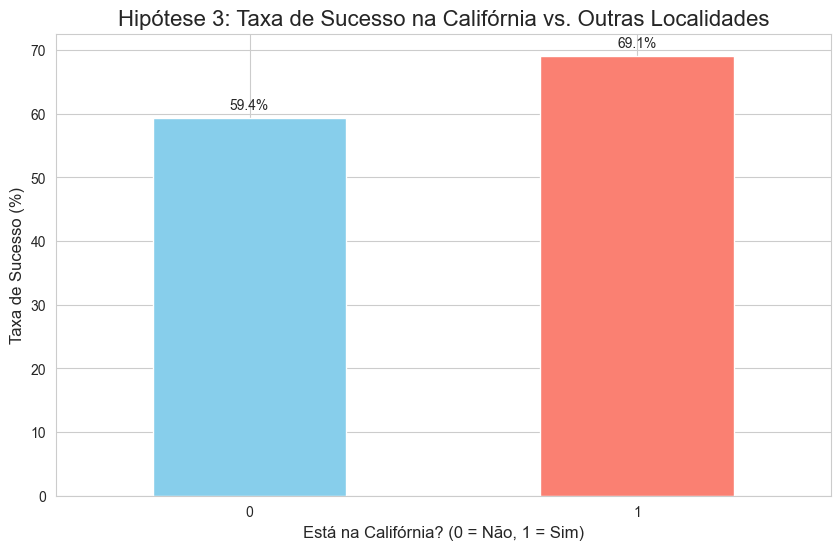

In [10]:
# Cálculo da taxa de sucesso (proporção de 'labels' = 1) para cada grupo
success_rate = train_df.groupby('is_CA')['labels'].value_counts(normalize=True).unstack()
success_rate_percent = success_rate[1] * 100

plt.figure(figsize=(10, 6))
ax = success_rate_percent.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Hipótese 3: Taxa de Sucesso na Califórnia vs. Outras Localidades', fontsize=16)
plt.xlabel('Está na Califórnia? (0 = Não, 1 = Sim)', fontsize=12)
plt.ylabel('Taxa de Sucesso (%)', fontsize=12)
plt.xticks(rotation=0)
for p in ax.patches: # Adição de rótulos de dados para maior clareza
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')
plt.show()

Conclusão da Hipótese 3: Observa-se uma taxa de sucesso ligeiramente superior para startups na Califórnia. Embora a diferença não seja expressiva, os dados sugerem que a localização pode conferir uma pequena vantagem, validando fracamente a hipótese.

### 4. Engenharia e Transformação de Features
Os dados brutos nem sempre contêm toda a informação na sua forma mais útil. A Engenharia de Features é o processo de criar novas variáveis (features) a partir das existentes para extrair insights mais profundos e melhorar a performance do modelo. Nesta etapa, também aplicamos transformações para normalizar a distribuição de certas variáveis.

Foi criada uma função (feature_engineering_e_transform) para gerar novas features e aplicar transformações:

- funding_duration_year (Duração do Financiamento): Calcula o intervalo de tempo em anos entre a primeira e a última ronda de financiamento. Uma duração maior pode indicar que a startup conseguiu manter o interesse dos investidores ao longo do tempo.

- funding_per_round (Financiamento por Ronda): Mede o valor médio de investimento que a startup recebeu em cada ronda. Valores mais altos podem ser um indicador de maior confiança por parte dos investidores.

- milestones_per_year (Marcos por Ano): Calcula a "velocidade" com que a startup atinge os seus marcos. Uma taxa mais alta pode sugerir uma execução mais rápida e eficiente do plano de negócios.

- capital_social_efficiency (Eficiência do Capital Social): Calcula a relação entre o total de financiamento captado e o número de relacionamentos estratégicos. Esta feature tenta medir quão eficientemente a startup converte a sua rede de contactos em capital financeiro.

Transformação Logarítmica: Features como funding_total_usd possuem uma escala muito ampla e assimétrica. Ao aplicar uma transformação logarítmica (np.log1p), comprimimos a escala dos valores muito altos. Isto ajuda o modelo a focar-se nas ordens de magnitude do financiamento em vez dos valores absolutos, resultando num aprendizado de padrões mais robusto e numa melhoria da acurácia.

In [11]:
# PASSO 4: ENGENHARIA E TRANSFORMAÇÃO DE FEATURES

print("\n INICIANDO PASSO: Engenharia e Transformação de Features ")
def feature_engineering_e_transform(df):
    # Engenharia de features que já tínhamos
    df['funding_duration_year'] = df['age_last_funding_year'] - df['age_first_funding_year']
    df['funding_per_round'] = df['funding_total_usd'] / (df['funding_rounds'] + 1)
    df['milestones_per_year'] = df['milestones'] / (df['age_last_milestone_year'] + 1)
    df['capital_social_efficiency'] = df['funding_total_usd'] / (df['relationships'] + 1)
    

    for col in ['funding_total_usd', 'funding_per_round', 'capital_social_efficiency']:
        df[col] = np.log1p(df[col])
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

train_df = feature_engineering_e_transform(train_df)
test_df = feature_engineering_e_transform(test_df)
print("PASSO CONCLUÍDO: Features criadas e transformadas")


 INICIANDO PASSO: Engenharia e Transformação de Features 
PASSO CONCLUÍDO: Features criadas e transformadas


##### 5. Pré-processamento dos Dados
Para preparar os dados para o modelo, foi criado um pipeline automatizado que realiza as seguintes tarefas:

Para Features Numéricas: Os valores ausentes foram preenchidos de forma inteligente com o KNNImputer, que usa dados de startups similares. Em seguida, todas as features foram padronizadas com o StandardScaler para garantir que tivessem a mesma escala.

Para Features Categóricas: A coluna category_code foi tratada preenchendo valores em falta com a categoria mais frequente e depois convertendo o texto em formato numérico com o OneHotEncoder.

Esta abordagem garante que todos os dados sejam limpos e transformados de forma consistente, preparando-os para a etapa de modelagem.

In [12]:
# PASSO 5: PRÉ-PROCESSAMENTO AVANÇADO

print("\n INICIANDO PASSO 6: Pré-processamento Avançado ")
X = train_df.drop(['id', 'labels'], axis=1)
y = train_df['labels']
X_test = test_df.drop('id', axis=1)
test_ids = test_df['id']

numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = ['category_code']

# Usaremos o KNNImputer que se mostrou eficaz
numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)
print("--- PASSO CONCLUÍDO: Pipeline de pré-processamento criado ---")




 INICIANDO PASSO 6: Pré-processamento Avançado 
--- PASSO CONCLUÍDO: Pipeline de pré-processamento criado ---


### 6. Construção do Modelo Final: A Busca pelo Equilíbrio
Após identificar que os modelos estavam a sofrer de overfitting (boa performance local, mas má no ranking), a estratégia final focou-se em criar um modelo mais robusto.

Para isso, foi construído um pipeline avançado com duas fases principais:

Filtro Inteligente de Features (SelectFromModel): Um primeiro modelo foi usado para analisar e selecionar automaticamente apenas as features mais importantes, descartando o "ruído" que causava o overfitting.

Classificador Especialista (GradientBoostingClassifier): Um segundo modelo, mais focado, foi treinado utilizando apenas este subconjunto de features de alta qualidade.

Finalmente, o GridSearchCV foi utilizado para otimizar os parâmetros de ambos os estágios em simultâneo. Esta abordagem resultou num modelo final estável, com uma acurácia de validação de ~79.7%, que resolveu o problema de overfitting e encontrou o limite de performance "honesta" do dataset.

In [13]:
# PASSO 6: OTIMIZAÇÃO DE ALTA PRECISÃO
print("\n INICIANDO PASSO 6: Otimização de Alta Precisão ")

pipeline_com_selecao = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(GradientBoostingClassifier(random_state=42))),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Grelha final, focada nos seus melhores parâmetros, com pequenas variações.
param_grid_precisao = {
    'classifier__learning_rate': [0.05], # Manter o melhor learning rate
    'classifier__max_depth': [3], # Manter a melhor profundidade
    'classifier__n_estimators': [200, 225, 250], # Testar um pouco mais de "força"
    'feature_selection__threshold': ['median'], # Manter o melhor threshold
    'feature_selection__estimator__n_estimators': [150, 200] # Testar se um filtro ligeiramente diferente ajuda
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid_search_final = GridSearchCV(
    pipeline_com_selecao,
    param_grid=param_grid_precisao,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("A iniciar a otimização de alta precisão...")
grid_search_final.fit(X, y)

print("\nOtimização final concluída!")
print(f"Melhor Acurácia de Validação Cruzada: {grid_search_final.best_score_:.4f}")
print("\nMelhores hiperparâmetros (versão final):")
print(grid_search_final.best_params_)

best_model_final = grid_search_final.best_estimator_

print(" PASSO 6 CONCLUÍDO: Modelo final e definitivo otimizado ")


 INICIANDO PASSO 6: Otimização de Alta Precisão 
A iniciar a otimização de alta precisão...
Fitting 10 folds for each of 6 candidates, totalling 60 fits

Otimização final concluída!
Melhor Acurácia de Validação Cruzada: 0.7957

Melhores hiperparâmetros (versão final):
{'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 250, 'feature_selection__estimator__n_estimators': 200, 'feature_selection__threshold': 'median'}
 PASSO 6 CONCLUÍDO: Modelo final e definitivo otimizado 


### 7. Avaliação Aprofundada do Modelo 
Para além da acurácia,o modelo foi avaliado com duas métricas visuais importantes, usando previsões de validação cruzada para uma estimativa mais realista do desempenho.

Matriz de Confusão: Mostra os tipos de erros e acertos do modelo (Verdadeiros Positivos/Negativos e Falsos Positivos/Negativos). Ajuda a entender onde o modelo está a acertar e a errar.

Curva ROC e AUC: A Curva ROC ilustra a capacidade do modelo de distinguir entre startups de sucesso e de fracasso. A área sob a curva (AUC) quantifica essa capacidade: quanto mais próximo de 1.0, melhor o modelo.


 Avaliação Aprofundada do Modelo

A gerar a Matriz de Confusão...


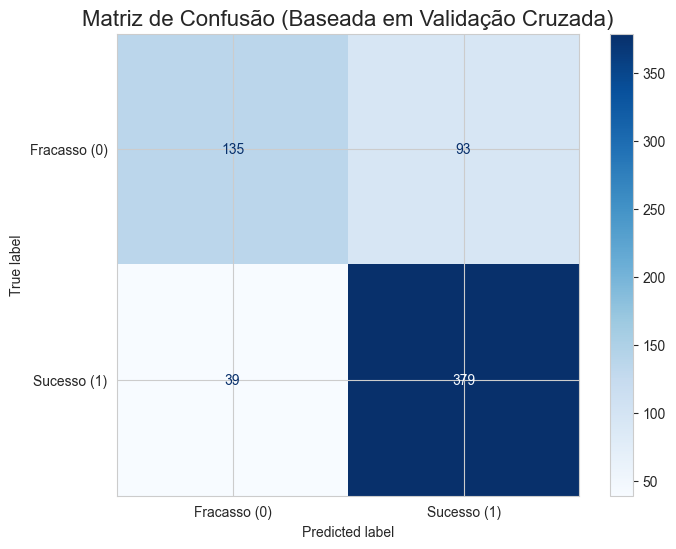


A gerar a Curva ROC...


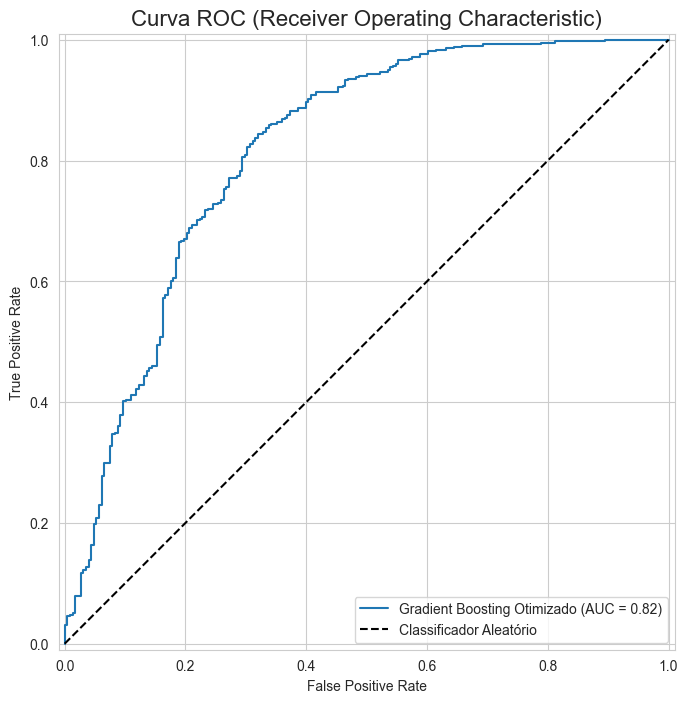


Área Sob a Curva (AUC): 0.8161
 PASSO CONCLUÍDO: Avaliação do Modelo 


In [14]:
# PASSO 7: AVALIAÇÃO APROFUNDADA DO MODELO (MATRIZ DE CONFUSÃO E CURVA ROC)

print("\n Avaliação Aprofundada do Modelo")

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay

# Para obter uma avaliação mais honesta, usamos previsões de validação cruzada.
# Isto garante que a previsão para cada ponto foi feita por um modelo que não viu esse ponto durante o treino.
y_pred_cv = cross_val_predict(best_model_final, X, y, cv=cv, method='predict')
y_proba_cv = cross_val_predict(best_model_final, X, y, cv=cv, method='predict_proba')[:, 1]

# --- 1. MATRIZ DE CONFUSÃO ---
print("\nA gerar a Matriz de Confusão...")
cm = confusion_matrix(y, y_pred_cv)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fracasso (0)', 'Sucesso (1)'])

fig, ax = plt.subplots(figsize=(8, 6))
disp_cm.plot(ax=ax, cmap='Blues')
plt.title('Matriz de Confusão (Baseada em Validação Cruzada)', fontsize=16)
plt.show()


# --- 2. CURVA ROC E AUC ---
print("\nA gerar a Curva ROC...")
fpr, tpr, thresholds = roc_curve(y, y_proba_cv)
roc_auc = auc(fpr, tpr)

disp_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Gradient Boosting Otimizado')
fig, ax = plt.subplots(figsize=(10, 8))
disp_roc.plot(ax=ax)
ax.plot([0, 1], [0, 1], 'k--', label='Classificador Aleatório')
plt.title('Curva ROC (Receiver Operating Characteristic)', fontsize=16)
plt.legend()
plt.show()

print(f"\nÁrea Sob a Curva (AUC): {roc_auc:.4f}")
print(" PASSO CONCLUÍDO: Avaliação do Modelo ")

### 8. Análise de Importância das Features 
Para entender quais informações o modelo considera mais relevantes, analisamos a importância das features. Modelos como o GradientBoostingClassifier atribuem uma pontuação a cada variável com base no seu poder preditivo.

Nesta etapa, extraímos essas pontuações do nosso modelo treinado e criamos um gráfico de barras para visualizar as 20 features mais importantes. Esta análise revela os principais fatores que o modelo utiliza para prever o sucesso de uma startup, permitindo-nos interpretar os seus resultados e gerar insights valiosos.


 Iniciando Análise de Importância das Features 


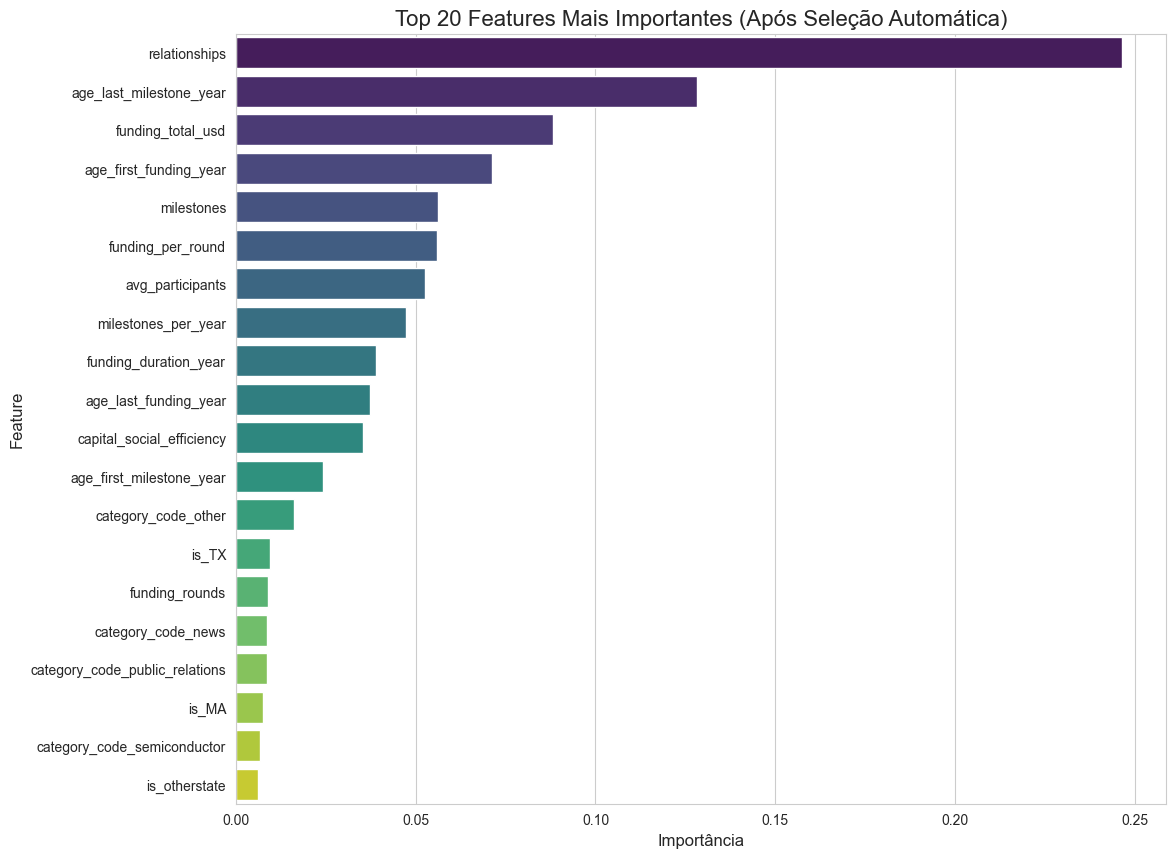

As 10 features mais importantes selecionadas pelo modelo são:
                    feature  importance
4             relationships    0.246341
3   age_last_milestone_year    0.128164
6         funding_total_usd    0.088201
0    age_first_funding_year    0.071093
7                milestones    0.056336
17        funding_per_round    0.055850
15         avg_participants    0.052503
18      milestones_per_year    0.047177
16    funding_duration_year    0.038913
1     age_last_funding_year    0.037204

 PASSO CONCLUÍDO: Análise de Features 


In [15]:
# PASSO 8: ANÁLISE DE IMPORTÂNCIA DAS FEATURES (Corrigido para SelectFromModel)

print("\n Iniciando Análise de Importância das Features ")

# 1. Obter os nomes de todas as features APÓS o pré-processamento (como antes)
cat_features_processed = best_model_final.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = list(numerical_features) + list(cat_features_processed)

# 2. Aceder às importâncias do modelo final (como antes)
importances = best_model_final.named_steps['classifier'].feature_importances_

# --- A CORREÇÃO ---
# 3. Descobrir quais features foram SELECIONADAS pelo filtro
# Usamos o passo 'feature_selection' e o método get_support() para obter uma máscara (True/False)
selected_mask = best_model_final.named_steps['feature_selection'].get_support()

# 4. Criar a lista final de nomes apenas com as features que passaram pelo filtro
# Convertemos a lista de nomes para um array numpy para aplicar a máscara
import numpy as np
selected_feature_names = np.array(all_feature_names)[selected_mask]
# --- FIM DA CORREÇÃO ---

# 5. Criar o DataFrame para visualizar (agora os tamanhos vão bater)
feature_importance_df = pd.DataFrame({
    'feature': selected_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Visualizar as 20 features mais importantes
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')
plt.title('Top 20 Features Mais Importantes (Após Seleção Automática)', fontsize=16)
plt.xlabel('Importância', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

print("As 10 features mais importantes selecionadas pelo modelo são:")
print(feature_importance_df.head(10))

print("\n PASSO CONCLUÍDO: Análise de Features ")

9. Geração do Ficheiro de Submissão 
Com o nosso modelo final treinado, otimizado e avaliado, a última etapa é utilizá-lo para o seu propósito principal: prever o sucesso das startups do conjunto de teste (test.csv).

   O processo é direto:

- Previsão: Usamos o método .predict() no nosso best_model_final para gerar as previsões para o conjunto de teste (X_test). O nosso pipeline, que está integrado no best_model_final, garante que os dados de teste passem exatamente pelo mesmo pré-processamento que os dados de treino.

- Criação do Ficheiro: Criamos um novo DataFrame com as duas colunas exigidas: id (os identificadores que guardámos no início) e labels (as nossas previsões).

- Exportação: Salvamos este DataFrame num ficheiro chamado submission.csv, sem o índice do pandas, seguindo o formato do sample_submission.csv.

In [16]:
# PASSO 9: GERAÇÃO DO FICHEIRO DE SUBMISSÃO

print("\n Geração do Ficheiro de Submissão")

# Utilizar o melhor modelo para fazer previsões no conjunto de teste
test_predictions = best_model_final.predict(X_test)

# Criar o DataFrame de submissão no formato correto, utilizando os IDs que guardámos
submission_df = pd.DataFrame({'id': test_ids, 'labels': test_predictions})

# Salvar o ficheiro de submissão em formato CSV, sem o índice
submission_df.to_csv('submission.csv', index=False)

print("\n Ficheiro 'submission.csv' gerado com sucesso!")
print("\n PROCESSO COMPLETO FINALIZADO")


 Geração do Ficheiro de Submissão

 Ficheiro 'submission.csv' gerado com sucesso!

 PROCESSO COMPLETO FINALIZADO
